# Определение выгодного тарифа для телеком компании

***Описание проекта:*** 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

***Описание тарифов:***

*Тариф «Смарт»*

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
    - Сообщение — 3 рубля.
    - 1 Гб интернет-трафика — 200 рублей.

*Тариф «Ультра»*

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - Минута разговора — 1 рубль;
    - Сообщение — 1 рубль;
    - 1 Гб интернет-трафика: 150 рублей.

***Описание данных:***

- `calls.csv` - данные по звонкам; 
- `internet.csv` - данные по использованию интернета;
- `messages.csv` - данные по использованию сообщений (SMS);
- `tariffs.csv` - данные о текущем тарифе;
- `users.csv` - данные о пользователе.

***План работы над проектом:***

1. Знакомство с данными и предобработка;
2. Агрегация данных; 
3. Анализ данных и подсчёт выручки; 
4. Проверка гипотез; 
5. Общий вывод.

### Знакомство с данными и предобработка

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

sns.set(rc={'figure.figsize': (15, 8)})

In [2]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        df.hist(figsize=(15, 8));

Для начала подгрузим таблицу со звонками.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

             duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000


,id,call_date,duration,user_id
55838,1142_482,2018-11-04,2.93,1142
57892,1146_111,2018-08-27,0.00,1146
108972,1281_405,2018-09-16,0.00,1281
152698,1380_333,2018-12-16,4.97,1380
17284,1048_74,2018-11-12,4.99,1048


Количество пропусков в таблице: 0 

id           0
call_date    0
duration     0
user_id      0
dtype: int64 

Количество дубликатов в таблице: 0


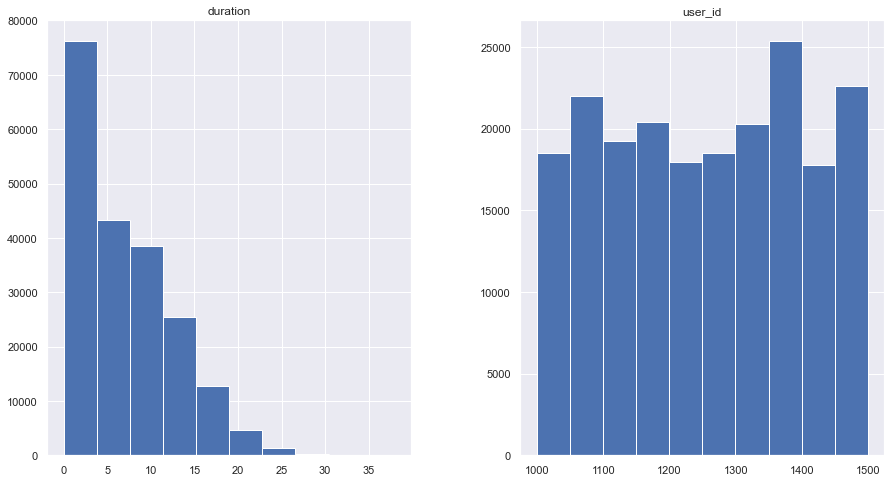

In [3]:
calls = pd.read_csv('calls.csv')
start(calls)

В таблице не правильно обозначен формат времени столбца. Переведём в правильный формат. 

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].dtypes

dtype('<M8[ns]')

Так же мы округлим продолжительность звонков и приведём к типу `int`.

In [5]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls['duration'].dtypes

dtype('int32')

В данных есть звонки с нулевой продолжительностью. Это обозначены пропущенные звонки, поэтому их не нужно удалять. Далее подгрузим таблицу `internet`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

           Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000


,Unnamed: 0,id,mb_used,session_date,user_id
121970,121970,1411_160,387.15,2018-07-27,1411
7552,7552,1026_20,0.00,2018-11-12,1026
92981,92981,1314_335,285.64,2018-08-21,1314
100638,100638,1338_28,173.04,2018-06-28,1338
105577,105577,1357_4,208.14,2018-10-16,1357


Количество пропусков в таблице: 0 

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64 

Количество дубликатов в таблице: 0


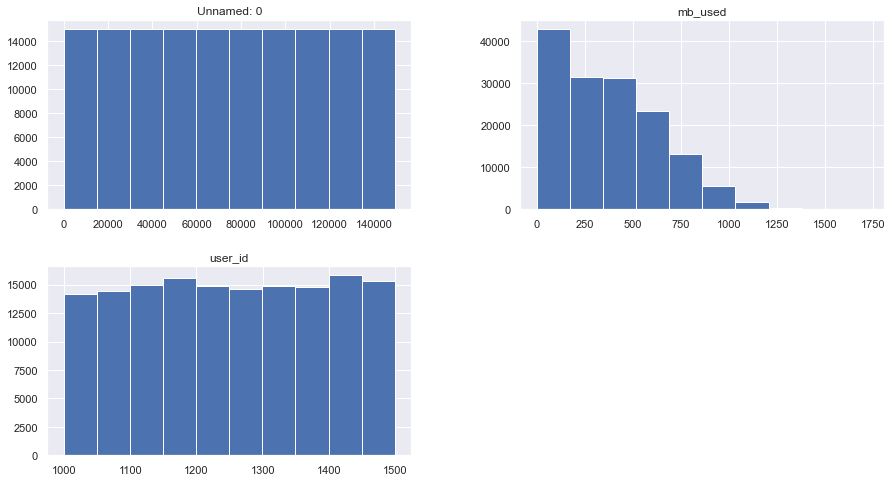

In [6]:
internet = pd.read_csv('internet.csv')
start(internet)

В этой таблице лишний столбец. Он появляется при неправильном экспорте данных, копируя индекс таблицы. Удалим `Unnamed: 0`.

In [7]:
internet = internet.drop(columns='Unnamed: 0', axis=1) 

Так же изменим столбец `session_date` в формат даты.

In [8]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].dtypes

dtype('<M8[ns]')

Хорошо. Дальше таблица `messages`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

              user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000


,id,message_date,user_id
63052,1275_14,2018-07-27,1275
99777,1409_78,2018-08-18,1409
38991,1167_297,2018-11-06,1167
44195,1191_310,2018-07-02,1191
106523,1431_265,2018-04-27,1431


Количество пропусков в таблице: 0 

id              0
message_date    0
user_id         0
dtype: int64 

Количество дубликатов в таблице: 0


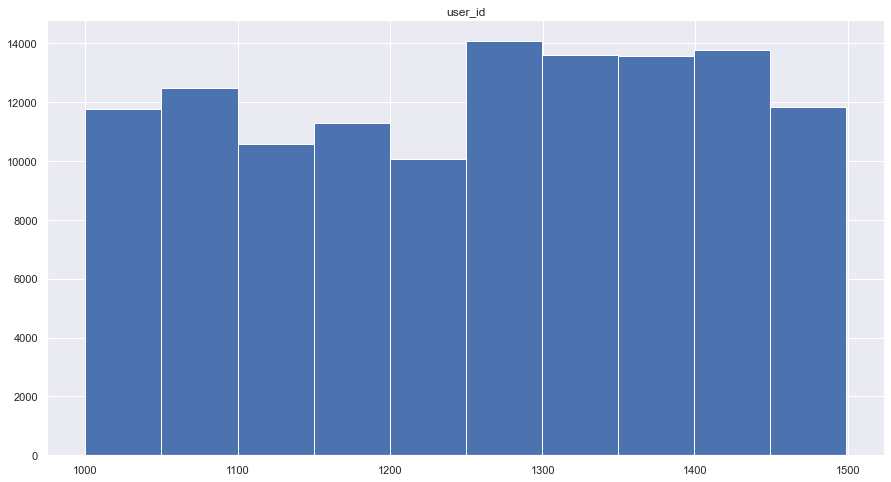

In [9]:
messages = pd.read_csv('messages.csv')
start(messages)

Здесь так же сменим тип столбца `message_date` на дату.

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].dtypes

dtype('<M8[ns]')

Теперь таблица `tariffs`.

In [11]:
tariffs = pd.read_csv('tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


С этой таблицей порядок. Всего `2 строки`, которые описывают тариф. Посмотрим на таблицу `users`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

            user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
248,1248,51,NaN,Москва,Анатолий,Минаев,2018-05-28,smart
11,1011,44,NaN,Самара,Веселина,Алёшко,2018-03-19,smart
92,1092,73,NaN,Ижевск,Вениамин,Амельченко,2018-06-19,smart
322,1322,45,NaN,Балашиха,Александр,Сальников,2018-09-09,smart
32,1032,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart


Количество пропусков в таблице: 462 

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64 

Количество дубликатов в таблице: 0


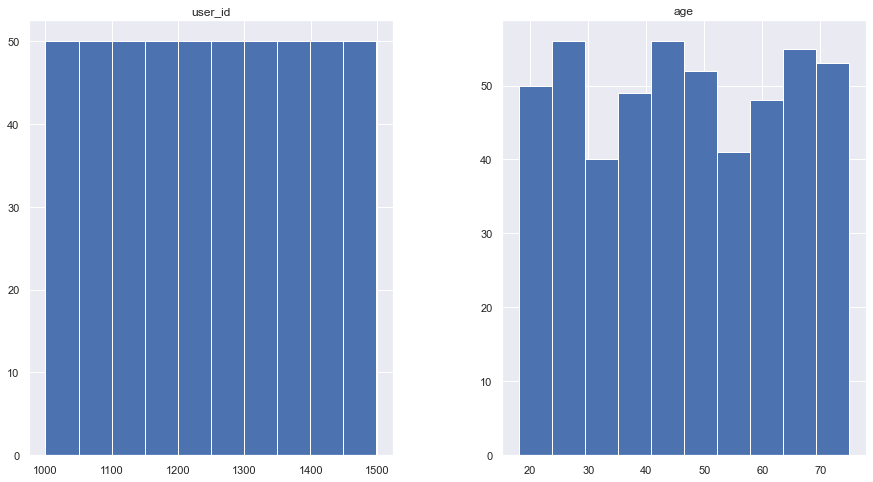

In [13]:
users = pd.read_csv('users.csv')
start(users)

Это данные пользовалетй, которые включают имя и фамилию. Тут сразу `2 столбца` требуюется перевести в формат даты. Это `churn_date` и `reg_date`.

In [14]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

users['churn_date'].dtypes

dtype('<M8[ns]')

В столбце `churn_date` (дата расторжения договора) есть `462 пропуска` из `500 записей`. Это активные пользователи компании.

***Вывод:*** В начале исследования мы подгрузили и обработали данные из 5 таблиц. Что именно мы сделали:
- перевели в формат даты столбцы из несколькоих таблиц, а именно `call_date session_date message_date churn_date и reg_date`;
- округлили продолжительность звонков и привели к типу `int`;
- обнаружили в данных звонки с нулевой продолжительностью. Это обозначены пропущенные звонки, поэтому их не стали удалять;
- удалили не нужный столбец с индексами в таблице `internet`;
- в столбце `churn_date` (дата расторжения договора) таблицы users есть `462 пропуска из 500 записей`. Это активные пользователи компании. Не стали заполнять пропуски.

### Агрегация данных

Создадим столбец `month` в датафрейме `calls` с номером месяца из столбца `call_date`.

In [15]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.sample(3)

,id,call_date,duration,user_id,month
200703,1495_90,2018-11-29,19,1495,11
4655,1012_129,2018-12-20,0,1012,12
134826,1344_643,2018-07-06,9,1344,7


Точно так же создадим столбец `month` в датафрейме `messages` с номером месяца из столбца `message_date`.

In [16]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
messages.sample(3)

,id,message_date,user_id,month
110286,1446_116,2018-12-12,1446,12
20502,1089_505,2018-08-21,1089,8
95010,1390_48,2018-09-20,1390,9


И создадим столбец `month` в датафрейме `internet` с номером месяца из столбца `session_date`. Все эти операции нужны для анализа по месяцам.

In [17]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
internet.sample(3)

,id,mb_used,session_date,user_id,month
149005,1497_119,1072.92,2018-12-22,1497,12
32304,1113_148,208.99,2018-07-14,1113,7
131374,1436_340,450.34,2018-08-04,1436,8


Далее посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам.

In [18]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
calls_per_month.head(15)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33

Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам.

In [19]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
minutes_per_month.head(15)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212

Так же посчитаем количество отправленных сообщений по месяцам для каждого пользователя.

In [20]:
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
messages_per_month.head(15)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12

Ну и посчитаем количество потраченных мегабайт по месяцам для каждого пользователя.

In [21]:
internet_per_month = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
internet_per_month.head(15)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25

Далее объединим все посчитанные выше значения в один датафрейм `user_behavior`. Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [22]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(internet_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
883,1142,4,67.0,24.0,22320.84,475.0,51,NaT,Новосибирск,Симона,Алешкова,2018-03-24,smart
1987,1314,3,56.0,31.0,23876.80,406.0,27,NaT,Киров,Максим,Амелишко,2018-03-04,smart
1881,1296,8,35.0,40.0,13664.16,226.0,60,NaT,Москва,Альфред,Черный,2018-06-05,smart


Проверим пропуски в таблице `user_behavior` после объединения.

In [23]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним образовавшиеся пропуски в данных нулевым значением.

In [24]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединяем информацию о тарифах, но в начале переименуем столбцец в таблице, чтобы получилось их связать по этому полю.

In [25]:
tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

In [26]:
user_behavior = user_behavior.merge(tariffs, on='tariff')
user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1554,1123,11,84.0,16.0,18327.99,548.0,74,NaT,Краснодар,Вениамин,Устинов,2018-03-18,smart,50,15360,500,550,200,3,3
2134,1248,9,104.0,0.0,23611.27,726.0,51,NaT,Москва,Анатолий,Минаев,2018-05-28,smart,50,15360,500,550,200,3,3
2801,1411,11,89.0,98.0,16051.49,584.0,36,NaT,Грозный,Берта,Прокофьева,2018-07-13,smart,50,15360,500,550,200,3,3


Считаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф.


In [27]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0
    
user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb
1631,1142,10,60.0,44.0,20860.79,457.0,51,NaT,Новосибирск,Симона,...,50,15360,500,550,200,3,3,0.0,0.0,5500.79
1019,1007,6,68.0,26.0,13654.52,545.0,65,NaT,Москва,Юна,...,50,15360,500,550,200,3,3,45.0,0.0,0.00
325,1185,8,121.0,0.0,42437.48,797.0,26,NaT,Санкт-Петербург,Мануэла,...,1000,30720,3000,1950,150,1,1,0.0,0.0,11717.48


Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`.

In [28]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)
user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb
2040,1227,4,81.0,28.0,21446.69,615.0,66,NaT,Санкт-Петербург,Раиса,...,15360,500,550,200,3,3,115.0,0.0,6086.69,6
1028,1009,4,39.0,14.0,14709.22,324.0,24,NaT,Пермь,Василиса,...,15360,500,550,200,3,3,0.0,0.0,0.00,0
2389,1308,2,31.0,21.0,13556.82,261.0,52,NaT,Москва,Инесса,...,15360,500,550,200,3,3,0.0,0.0,0.00,0


Считаем выручку за минуты разговора, сообщения и интернет.

In [29]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,...,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb,cost_minutes,cost_messages,cost_gb
2690,1388,9,64.0,0.0,22535.13,481.0,24,NaT,Вологда,Рустам,...,200,3,3,0.0,0.0,7175.13,8,0.0,0.0,1600
2120,1246,11,46.0,10.0,25623.85,314.0,27,NaT,Санкт-Петербург,Марта,...,200,3,3,0.0,0.0,10263.85,11,0.0,0.0,2200
2928,1433,12,74.0,97.0,16471.38,516.0,71,NaT,Подольск,Клариса,...,200,3,3,16.0,47.0,1111.38,2,48.0,141.0,400


Считаем помесячную выручку с каждого пользователя, она будет храниться в столбец `total_cost`.

In [30]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

user_behavior.sample(3)

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,...,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb,cost_minutes,cost_messages,cost_gb,total_cost
496,1277,11,32.0,140.0,10349.28,232.0,30,NaT,Новосибирск,Валерия,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
2935,1435,7,41.0,0.0,20292.20,234.0,32,NaT,Москва,Евфросинья,...,3,3,0.0,0.0,4932.2,5,0.0,0.0,1000,1550.0
3100,1478,8,45.0,75.0,13121.79,305.0,75,NaT,Грозный,Таира,...,3,3,0.0,25.0,0.0,0,0.0,75.0,0,625.0


Датафрейм `stats_df` для каждой пары "месяц-тариф" будет хранить основные характеристики.

In [31]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'internet_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'internet_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'internet_median', 'messages_median',  'minutes_median']

stats_df.sample(5)

,month,tariff,calls_mean,internet_mean,messages_mean,minutes_mean,calls_std,internet_std,messages_std,minutes_std,calls_median,internet_median,messages_median,minutes_median
20,11,smart,61.50,16895.70,34.08,435.27,24.80,5340.27,28.39,177.78,60.0,17013.80,28.0,428.5
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5


***Вывод:*** В этапе агрегации мы добавили к таблицам с данными солбцы `month` выделив туда месяц события. Данные объединили по месяцам для каждого пользователя используя даннные по количеству звонков и их продолжительности, отправленных сообщений, использованого инернета. Объединили все посчитанные значения в один датафрейм `user_behavior`.

После объединения в таблице обнаружились пропуски. Заполнили образовавшиеся пропуски в данных нулевым значением. 
- далее присоединили информацию о тарифах, но в начале переименовали столбцец `tariffs` в таблице, чтобы получилось их связать по этому полю;
- посчитали количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф;
- перевели превышающие тариф мегабайты в гигабайты и сохранив их в столбец `paid_gb`;
- посчитали выручку за минуты разговора, сообщения и интернет;
- вывели помесячную выручку с каждого пользователя и сохранили в столбец `total_cost`;
- создали датафрейм `stats_df`. Для каждой пары "месяц-тариф" он хранит основные характеристики (mean, std, median).

### Анализ данных и подсчёт выручки

Посмотрим долю расторгунтых договоров в исходных данных.

In [32]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор `7.6% клиентов` из датасета.

Хорошо. Построим распределение среднего количества звонков по видам тарифов и месяцам.

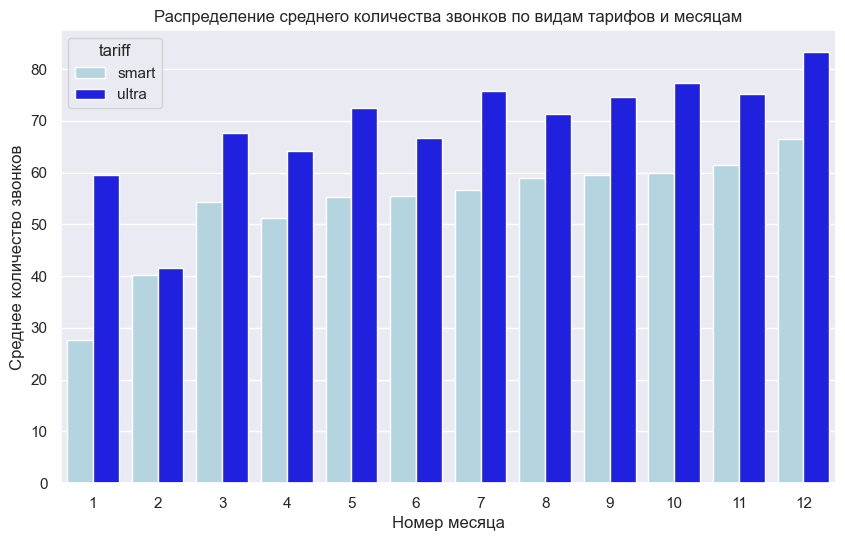

In [33]:
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение среднего количества звонков по видам тарифов и месяцам');
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

Теперь построим распределение количества клиентов и количеством звонков по видам тарифов.

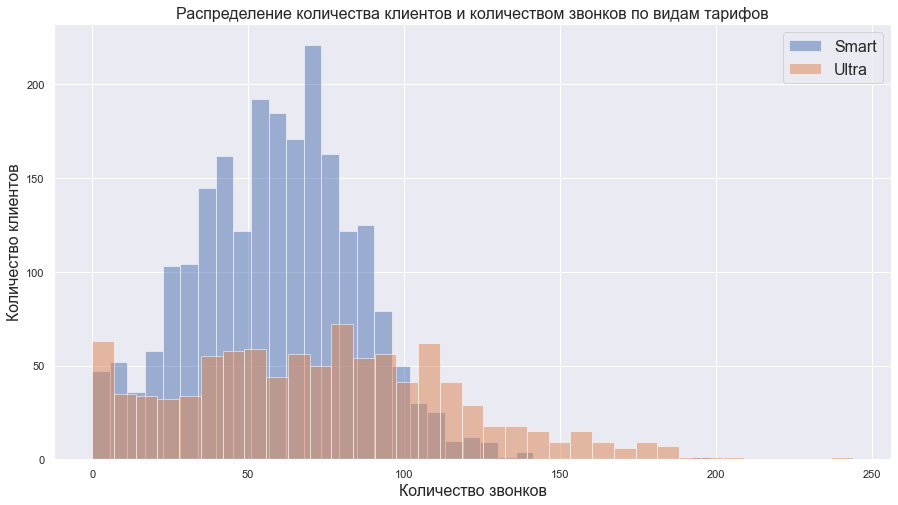

In [34]:
sns.set(rc={'figure.figsize': (15, 8)})
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)

plt.title('Распределение количества клиентов и количеством звонков по видам тарифов', size=16)
plt.legend(['Smart', 'Ultra'], fontsize=16)
plt.xlabel('Количество звонков', size=16)
plt.ylabel('Количество клиентов', size=16)
plt.show()

Построим распределение средней продолжительности звонков по видам тарифов и месяцам.

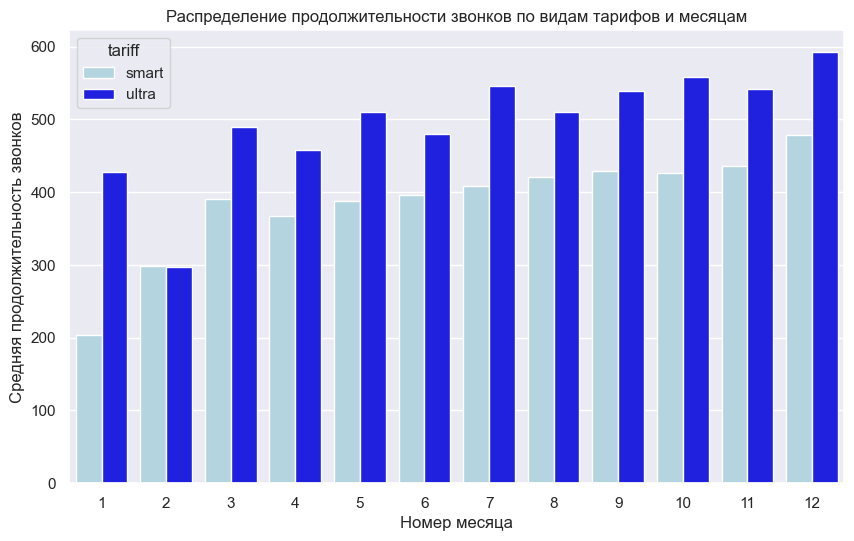

In [35]:
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам'); 
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

По графикам о звонках мы можем сделать выводы, что:
- средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart и количество звонков у них же больше;
- в течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели;
- рост средней длительности разговоров у абонентов тарифа Smart имеет нормальное распределение в течение года. Пользователи тарифа Ultra не проявляют подобной стабильности. 

Теперь построим распределение среднего количества сообщений по видам тарифов и месяцам.

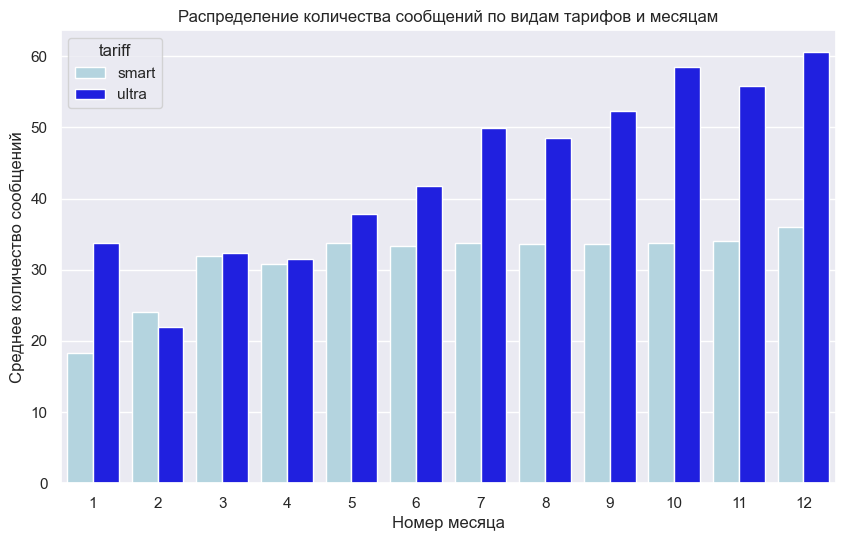

In [36]:
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

Далее график распределение количества клиентов и количества сообщений по видам тарифов.

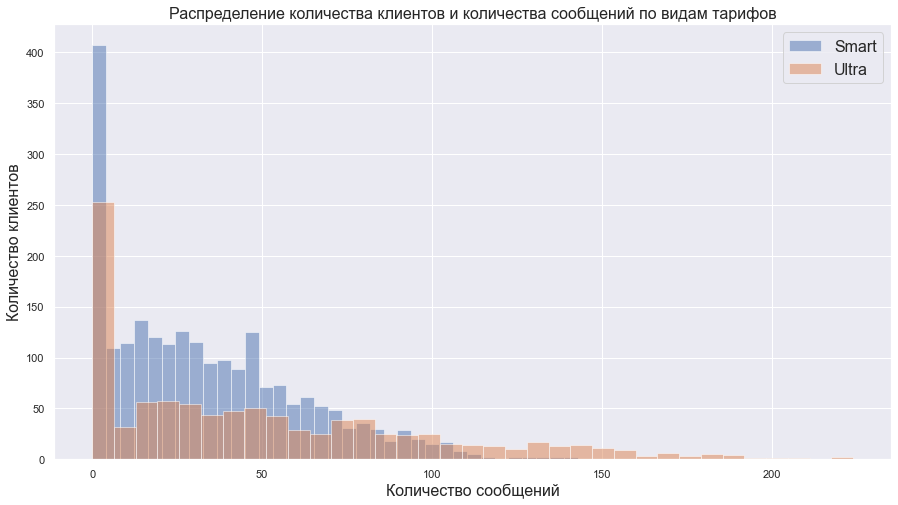

In [37]:
sns.set(rc={'figure.figsize': (15, 8)})
user_behavior.groupby('tariff')['messages'].plot(kind='hist', bins=35, alpha=0.5)

plt.title('Распределение количества клиентов и количества сообщений по видам тарифов', size=16)
plt.legend(['Smart', 'Ultra'], fontsize=16)
plt.xlabel('Количество сообщений', size=16)
plt.ylabel('Количество клиентов', size=16)
plt.show()

По графикам о звонках мы можем сделать выводы, что:
- по среднему по количеству сообщений пользователи тарифа Ultra отправляют их больше. В среднем больше на 20 сообщений в месяц. В первых месяцах года, не считая январь, показатели для двух тарифов очень похожи. Во второй половине у абонентв Ultra показатели возрастяют в то время как у Smart они остаются достаточно ровными; 
- количество сообщений в течение года на обоих тарифах растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров; 
- так же мы заметили, то много людей либо не пользуются смс либо отправляют их очень мало.

Построим распределение пользователей по интернет трафику в месяц.

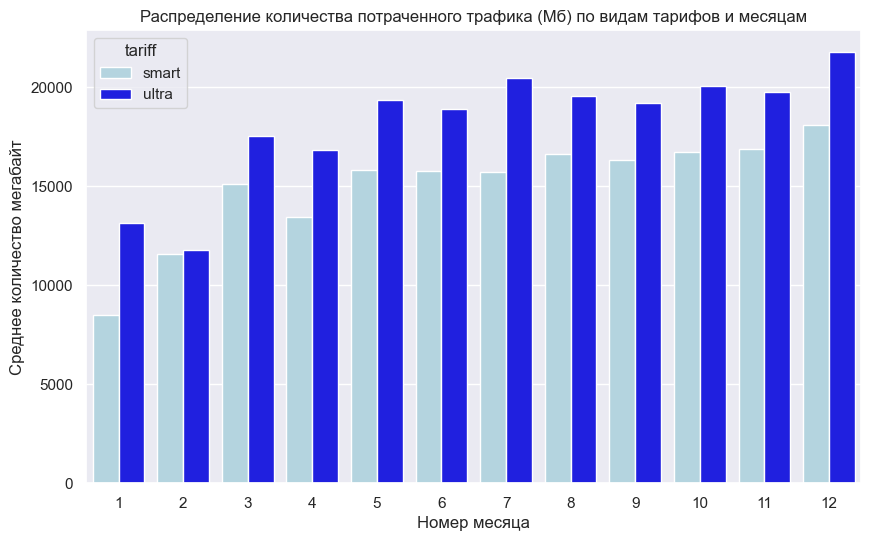

In [38]:
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.barplot(x='month',
            y='internet_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравним количество потраченных мегабайт среди пользователей тарифов Smart и Ultra.

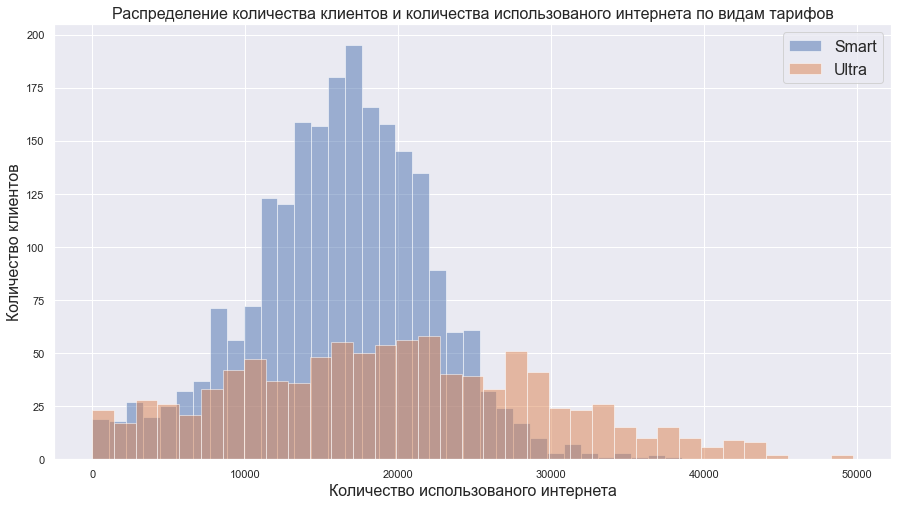

In [39]:
sns.set(rc={'figure.figsize': (15, 8)})
user_behavior.groupby('tariff')['mb_used'].plot(kind='hist', bins=35, alpha=0.5)

plt.title('Распределение количества клиентов и количества использованого интернета по видам тарифов', size=16)
plt.legend(['Smart', 'Ultra'], fontsize=16)
plt.xlabel('Количество использованого интернета', size=16)
plt.ylabel('Количество клиентов', size=16)
plt.show()

По графикам о количествеа использованого интернета мы можем сделать выводы, что:
- меньше всего пользователи использовали интернет в январе, феврале и апреле; 
- в среднем абоненты тарифа Smart тратят `15-17 гигабайт` трафика, а абоненты тарифного плана Ultra - `19-21` в месяц.

Теперь построим `3 графика`, которые описывают превышение лимитов по каждому пункту тарифа.

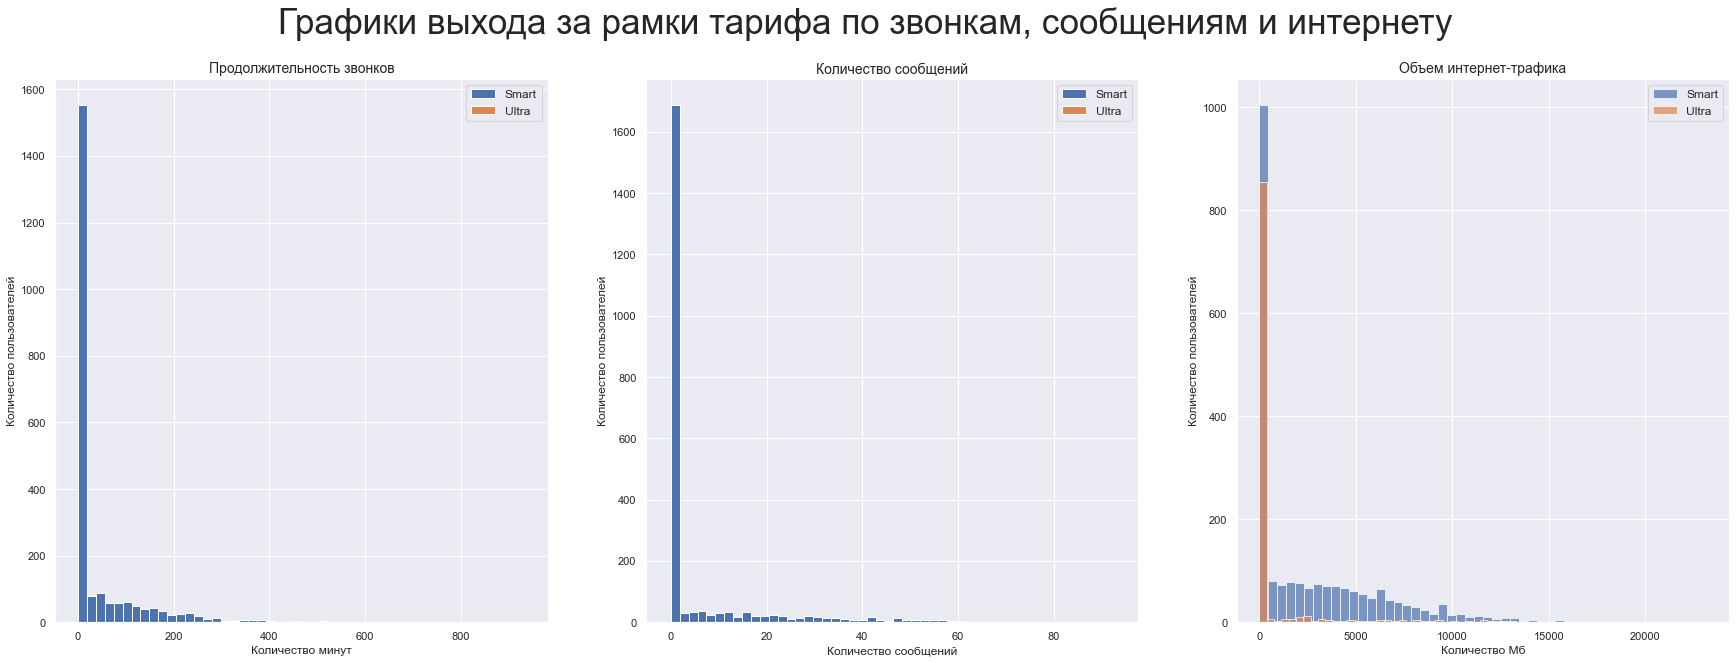

In [40]:
sns.set(rc={'figure.figsize': (30, 10)})
fig, ax = plt.subplots(1, 3)

user_behavior.groupby('tariff')['paid_minutes'].plot(kind='hist', ax=ax[0], bins=50)
ax[0].set_title('Продолжительность звонков', fontsize=14)
ax[0].set_xlabel('Количество минут')
ax[0].set_ylabel('Количество пользователей')
ax[0].legend(['Smart', 'Ultra'], fontsize=12)

user_behavior.groupby('tariff')['paid_messages'].plot(kind='hist', ax=ax[1], bins=50)
ax[1].set_title('Количество сообщений', fontsize=14)
ax[1].set_xlabel('Количество сообщений')
ax[1].set_ylabel('Количество пользователей')
ax[1].legend(['Smart', 'Ultra'], fontsize=12)

user_behavior.groupby('tariff')['paid_mb'].plot(kind='hist', ax=ax[2], bins=50, alpha=0.7)
ax[2].set_title('Объем интернет-трафика', fontsize=14)
ax[2].set_xlabel('Количество Мб')
ax[2].set_ylabel('Количество пользователей')
ax[2].legend(['Smart', 'Ultra'], fontsize=12)

fig.suptitle('Графики выхода за рамки тарифа по звонкам, сообщениям и интернету', fontsize=35)

plt.show()

По графику чётко видно, что много превышений по лимитам у тарифа Smart относительно тарифа Ultra. Особенно по звонкам и интернету.

***Вывод:*** Этап анализа данных мы начали с того, что посмотрели долю расторгунтых договоров в исходных данных. Расторгли договор `7.6% клиентов` из датасета. 

Далее мы строили графики и анализировали. Начали со звонков. Построили:
- распределение среднего количества звонков по видам тарифов и месяцам;
- распределение количества клиентов и количеством звонков по видам тарифов;
- распределение средней продолжительности звонков по видам тарифов и месяцам.

По этим графикам сделали выводы, что:
- средняя длительность разговоров у абонентов тарифа `Ultra` больше, чем у абонентов тарифа `Smart` и количество звонков у них же больше;
- в течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели;
- рост средней длительности разговоров у абонентов тарифа `Smart` имеет нормальное распределение в течение года. Пользователи тарифа `Ultra` нет.

Потом мы строили графики для сообщений:
- распределение среднего количества сообщений по видам тарифов и месяцам; 
- распределение количества клиентов и количества сообщений по видам тарифов.

Мы сделали выводы, что:
- по среднему по количеству сообщений пользователи тарифа `Ultra` отправляют их больше. В среднем `больше на 20 сообщений` в месяц. В первых месяцах года, не считая январь, показатели для двух тарифов очень похожи. Во второй половине у абонентв `Ultra` показатели возрастяют в то время как у `Smart` они остаются достаточно ровными; 
- количество сообщений в течение года на обоих тарифах растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров; 
- так же мы заметили, то много людей либо не пользуются смс либо отправляют их очень мало.

Так же мы строили графики по данным расхода интернета:
- распределение пользователей по интернет трафику в месяц; 
- количество потраченных мегабайт среди пользователей тарифов Smart и Ultra.

По графикам о количествеа использованого интернета мы можем сделать выводы, что:
- меньше всего пользователи использовали интернет в январе, феврале и апреле; 
- в среднем абоненты тарифа `Smart` тратят `15-17 гигабайт` трафика, а абоненты тарифного плана `Ultra` - `19-21` в месяц.

В конце мы построили `3 графика`, которые описывают превышение лимитов по каждому пункту тарифа.
По ним чётко видно, что много превышений по лимитам у тарифа `Smart` относительно тарифа `Ultra`. Особенно по звонкам и интернету.

### Проверка гипотез

Определим `2 гипотезы` и проверим на наших данных. За `alpha возьмём значение 0.05` 

Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"
alpha = 0.05
```

In [41]:
alpha = 0.05

results = st.ttest_ind(
    user_behavior[user_behavior['tariff'] =='smart']['total_cost'], 
    user_behavior[user_behavior['tariff'] =='ultra']['total_cost'], equal_var=False)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Проверка гипотезы: пользователи из Москвы приносят больше выручки, чем пользователи из других городов.

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы
alpha = 0.05
```

In [42]:
alpha = 0.05

results = st.ttest_ind(
    user_behavior[(user_behavior['city'] =='Москва')]['total_cost'], 
    user_behavior[(user_behavior['city'] !='Москва')]['total_cost'], equal_var=False)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Ну и для ответа на вопрос от заказчика "какой тариф выгоднее для оператора связи" сравним среднее значенеи выручки от абонентов.

In [43]:
# средняя выручка от клиентов тарифа Smart 
user_behavior[user_behavior['tariff'] == 'smart']['total_cost'].sum().mean()

2875351.0

In [44]:
# средняя выручка от клиентов тарифа Ultra 
user_behavior[user_behavior['tariff'] == 'ultra']['total_cost'].sum().mean()

2039100.0

Видим, что значительный перевес в выгоду оператора у тариф Smart.

***Вывод:*** В этапе проверки гипотез мы проверяли `2 гипотезы`.

Первая, что "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" - она подтвердилась показав `p-value ~ 4.26` и отклонив нулевую гипотезу:
```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"
```

Вторая, что "пользователи из Москвы приносят больше выручки, чем пользователи из других городов" - она не подвердилась показав `p-value ~ 0.52` и не отклонив нулевую гипотезу:
```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы
```
Тут же мы отвелили на вопрос от заказчика: "какой тариф выгоднее для оператора связи" сравнив средние значенеи выручки от `2 тарифов`. Как итогу у `Smart 2875351`, а у `Ultra 2039100`. Smart выгоднее для операторов.

### Общий вывод

В начале исследования мы подгрузили и обработали данные из 5 таблиц. Что именно мы сделали:
- перевели в формат даты столбцы из несколькоих таблиц, а именно `call_date session_date message_date churn_date и reg_date`;
- округлили продолжительность звонков и привели к типу `int`;
- обнаружили в данных звонки с нулевой продолжительностью. Это обозначены пропущенные звонки, поэтому их не стали удалять;
- удалили не нужный столбец с индексами в таблице `internet`;
- в столбце `churn_date` (дата расторжения договора) таблицы users есть `462 пропуска из 500 записей`. Это активные пользователи компании. Не стали заполнять пропуски.

В этапе агрегации мы добавили к таблицам с данными солбцы `month` выделив туда месяц события. Данные объединили по месяцам для каждого пользователя используя даннные по количеству звонков и их продолжительности, отправленных сообщений, использованого инернета. Объединили все посчитанные значения в один датафрейм `user_behavior`.

После объединения в таблице обнаружились пропуски. Заполнили образовавшиеся пропуски в данных нулевым значением. 
- далее присоединили информацию о тарифах, но в начале переименовали столбцец `tariffs` в таблице, чтобы получилось их связать по этому полю;
- посчитали количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф;
- перевели превышающие тариф мегабайты в гигабайты и сохранив их в столбец `paid_gb`;
- посчитали выручку за минуты разговора, сообщения и интернет;
- вывели помесячную выручку с каждого пользователя и сохранили в столбец `total_cost`;
- создали датафрейм `stats_df`. Для каждой пары "месяц-тариф" он хранит основные характеристики (mean, std, median).

Этап анализа данных мы начали с того, что посмотрели долю расторгунтых договоров в исходных данных. Расторгли договор `7.6% клиентов` из датасета. 

Далее мы строили графики и анализировали. Начали со звонков. Построили:
- распределение среднего количества звонков по видам тарифов и месяцам;
- распределение количества клиентов и количеством звонков по видам тарифов;
- распределение средней продолжительности звонков по видам тарифов и месяцам.

По этим графикам сделали выводы, что:
- средняя длительность разговоров у абонентов тарифа `Ultra` больше, чем у абонентов тарифа `Smart` и количество звонков у них же больше;
- в течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели;
- рост средней длительности разговоров у абонентов тарифа `Smart` имеет нормальное распределение в течение года. Пользователи тарифа `Ultra` нет.

Потом мы строили графики для сообщений:
- распределение среднего количества сообщений по видам тарифов и месяцам; 
- распределение количества клиентов и количества сообщений по видам тарифов.

Мы сделали выводы, что:
- по среднему по количеству сообщений пользователи тарифа `Ultra` отправляют их больше. В среднем `больше на 20 сообщений` в месяц. В первых месяцах года, не считая январь, показатели для двух тарифов очень похожи. Во второй половине у абонентв `Ultra` показатели возрастяют в то время как у `Smart` они остаются достаточно ровными; 
- количество сообщений в течение года на обоих тарифах растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров; 
- так же мы заметили, то много людей либо не пользуются смс либо отправляют их очень мало.

Так же мы строили графики по данным расхода интернета:
- распределение пользователей по интернет трафику в месяц; 
- количество потраченных мегабайт среди пользователей тарифов Smart и Ultra.

По графикам о количествеа использованого интернета мы можем сделать выводы, что:
- меньше всего пользователи использовали интернет в январе, феврале и апреле; 
- в среднем абоненты тарифа `Smart` тратят `15-17 гигабайт` трафика, а абоненты тарифного плана `Ultra` - `19-21` в месяц.

В конце мы построили `3 графика`, которые описывают превышение лимитов по каждому пункту тарифа.
По ним чётко видно, что много превышений по лимитам у тарифа `Smart` относительно тарифа `Ultra`. Особенно по звонкам и интернету.

В этапе проверки гипотез мы проверяли `2 гипотезы`.

Первая, что "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" - она подтвердилась показав `p-value ~ 4.26` и отклонив нулевую гипотезу:
```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"
```

Вторая, что "пользователи из Москвы приносят больше выручки, чем пользователи из других городов" - она не подвердилась показав `p-value ~ 0.52` и не отклонив нулевую гипотезу:
```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы
```
Тут же мы отвелили на вопрос от заказчика: "какой тариф выгоднее для оператора связи" сравнив средние значенеи выручки от `2 тарифов`. Как итогу у `Smart 2875351`, а у `Ultra 2039100`. Smart выгоднее для операторов.